In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd

import copy

In [2]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


### Import plotting utilities and planar drone locally or from github

In [3]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')

# Planar drone dynamics

Now all the drone dynamics are in the helper file, `planar_drone.py`

#### Given the planar drone dynamics

$
\mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}) =
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[yellow]{x} \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
\bbox[pink]{k}
\end{bmatrix} =
\overset{f_0}{\begin{bmatrix}
\bbox[yellow]{\dot{\theta}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
-\bbox[lightblue]{g} \\[0.3em]
0
\end{bmatrix}} +
\overset{f_1}{\begin{bmatrix}
0 \\[0.3em]
\bbox[lightblue]{l}\bbox[pink]{k}/\bbox[lightblue]{I_{yy}} \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_1} +
\overset{f_2}{\begin{bmatrix}
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
-\bbox[pink]{k}\bbox[yellow]{\sin\theta}/\bbox[lightblue]{m} \\[0.3em]
0 \\[0.3em]
\bbox[pink]{k}\bbox[yellow]{\cos\theta}/\bbox[lightblue]{m}  \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_2}
$

#### Consider the following sensor combinations:

$
\mathbf{y_a} = \mathbf{{h_a}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{x} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\bbox[pink]{k}
\end{bmatrix}
$

$
\mathbf{y_b} = \mathbf{{h_b}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{\dot{x}}/\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\theta} \\[0.3em]
\bbox[pink]{k}
\end{bmatrix}
$

$
\mathbf{y_c} = \mathbf{{h_c}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{\dot{x}}/\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}}   \\[0.3em]
\ddot{x} = -\bbox[pink]{k} \sin(\bbox[yellow]{\theta}) \bbox[lightgreen]{j_1} / \bbox[lightblue]{m}  \\[0.3em]
\ddot{z} = -\bbox[lightblue]{g} / \bbox[lightblue]{m} + \bbox[pink]{k} \cos(\bbox[yellow]{\theta}) \bbox[lightgreen]{j_2}/ \bbox[lightblue]{m}
\end{bmatrix}
$

# Dynamics and measurement functions

In [5]:
f = planar_drone.F().f
h = planar_drone.H('h_camera_imu').h

# Run MPC simulation

In [7]:
t_sim, x_sim, u_sim, y_sim, simulator = planar_drone.simulate_drone(f, h=h, dt=0.1, tsim_length=20,
                                                                    trajectory_shape='alternating')

### Plot the x, z trajectory

Text(0, 0.5, 'z pos')

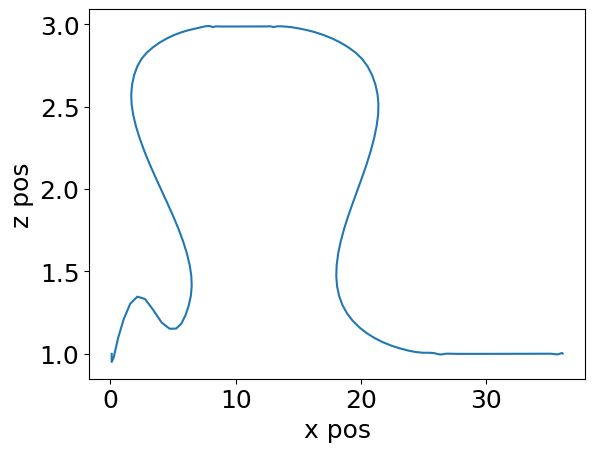

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_sim['x'], x_sim['z'])

ax.set_xlabel('x pos')
ax.set_ylabel('z pos')

### Plot $\dot{x}$ vs time and $\dot{z}$ vs time.

Text(0, 0.5, 'x and z vel')

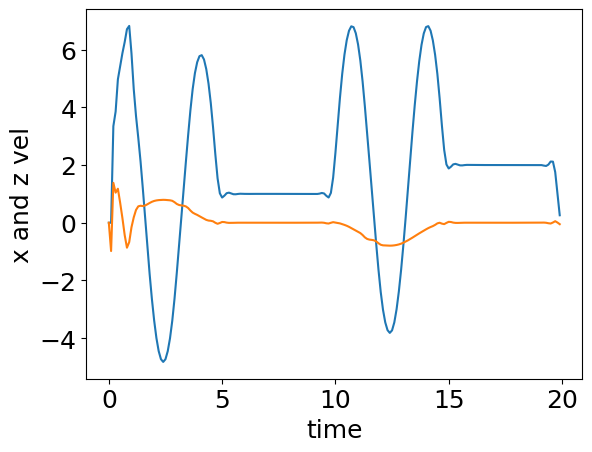

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_sim, x_sim['x_dot'])
ax.plot(t_sim, x_sim['z_dot'])

ax.set_xlabel('time')
ax.set_ylabel('x and z vel')

# Define noise characteristics

Choose noise properties for each sensor, and apply the noise to each measurement stream

In [10]:
measurement_noise_stds = {'optic_flow': 1,
                          'theta': 0.1,
                          'theta_dot': 0.1,
                          'accel_x': 0.2,
                          'accel_z': 0.2,
                          #'k': 0.1,
                         }

### Save data as dataframes

In [11]:
u_sim_df = pd.DataFrame(u_sim)
x_sim_df = pd.DataFrame(x_sim)

# Observability analysis

In [12]:
w = 6  # window size, set to None to use entire time-series as one window

### This is the computationally heavy step

Here we calculate the observability matrix for each sliding window, all the states, and measurements. Later we can subselect from this to choose specific time steps, measurements, states, etc. to consider.

In [13]:
# Construct O in sliding windows
SEOM = pybounds.SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=w, eps=1e-4)

# Get O's
O_sliding = SEOM.get_observability_matrix()

In [14]:
n_window = len(O_sliding)
print(n_window, 'windows')

195 windows


### Look at one of the observability matrices

In [15]:
O_sliding[0]

,,theta,theta_dot,x,x_dot,z,z_dot,k
sensor,time_step,,,,,,,
optic_flow,0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
theta,0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
theta_dot,0,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
accel_x,0,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
accel_z,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
optic_flow,1,-1.370959e-09,-6.624155e-11,0.000000e+00,1.051580e+00,-2.853290e-10,-2.853291e-11,5.014313e-10
theta,1,1.000000e+00,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.235988e-01
theta_dot,1,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.047198e+01
accel_x,1,-8.660254e-01,-8.660254e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.534498e-01


### Convert a single observability matrix into fisher information

$F = \mathcal{O}_w^T R_w^{-1} \mathcal{O}_w$

In [20]:
measurement_noise_vars = {key: val**2 for key, val in measurement_noise_stds.items()}

In [21]:
# Compute the Fisher information & Chernoff inverse
FO = pybounds.FisherObservability(SEOM.O_df_sliding[0], measurement_noise_vars, lam=1e-8)

In [22]:
# Get the Fisher information, inverse, and R matrix
F, F_inv, R = FO.get_fisher_information()
F_inv

,theta,theta_dot,x,x_dot,z,z_dot,k
theta,0.001438,-0.000378,1.081274e-04,2.282106e-06,-0.000016,-0.007510,1.750892e-05
theta_dot,-0.000378,0.001735,-9.417841e-04,-1.104157e-06,0.000357,-0.000183,9.385855e-05
x,0.000108,-0.000942,1.000000e+08,-7.823767e-03,0.076863,-0.572749,8.411755e-06
x_dot,0.000002,-0.000001,-7.823759e-03,4.742168e-01,0.158418,-0.093748,2.553573e-08
z,-0.000016,0.000357,7.686348e-02,1.584185e-01,0.288773,-0.649762,1.173615e-04
z_dot,-0.007510,-0.000183,-5.727494e-01,-9.374774e-02,-0.649762,1.855038,-1.639596e-04
k,0.000018,0.000094,8.411790e-06,2.553573e-08,0.000117,-0.000164,6.928301e-05


### Efficiently repeat the above process for a specific set of sensors, states, and time points

In [28]:
# Choose sensors to use from O
o_sensors = ['optic_flow', 'theta', 'theta_dot', 'accel_x', 'accel_z']

# Chose states to use from O
o_states = ['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot', 'k']

# Choose time-steps to use from O
window_size = 6 # this cannot be larger than what was defined above
o_time_steps = np.arange(0, window_size, step=1)

# Redefine R -- if you remove a sensor you need to change R
o_measurement_noise_vars = {key: measurement_noise_vars[key] for key in o_sensors}

In [29]:
# Compute the Fisher information & inverse for each window and store the minimum error variance
SFO = pybounds.SlidingFisherObservability(SEOM.O_df_sliding, time=SEOM.t_sim, lam=1e-8, R=o_measurement_noise_vars,
                                 states=o_states, sensors=o_sensors, time_steps=o_time_steps, w=None)

# If you want to manually inspect one of the fisher info matrices:
# SFO.FO[1].O

In [30]:
# Pull out minimum error variance, 'time' column is the time vector shifted forward by w/2 and 'time_initial' is the original time
EV_aligned = SFO.get_minimum_error_variance()

In [31]:
EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')

# Plot observability over time

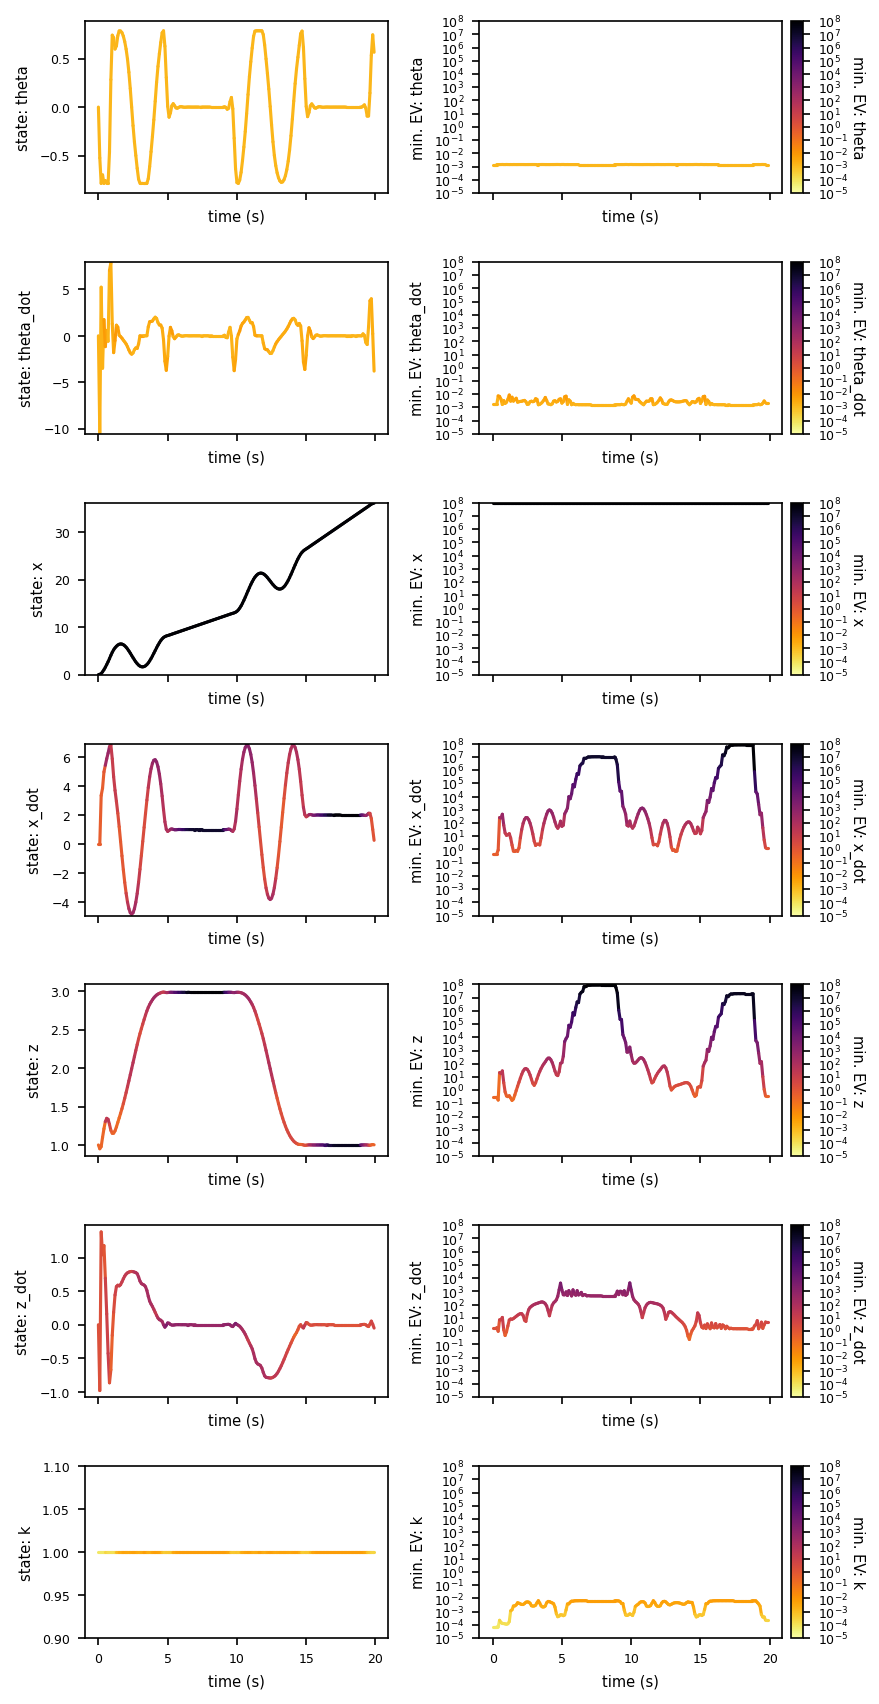

In [32]:
states = list(SFO.FO[0].O.columns)
n_state = len(states)

fig, ax = plt.subplots(n_state, 2, figsize=(6, n_state*2), dpi=150, sharex=True)
ax = np.atleast_2d(ax)

cmap = 'inferno_r'

min_ev = np.min(EV_no_nan.iloc[:, 2:].values)
max_ev = np.max(EV_no_nan.iloc[:, 2:].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    pybounds.colorline(t_sim, x_sim[state_name], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    pybounds.colorline(t_sim, EV_no_nan[state_name].values, EV_no_nan[state_name].values, ax=ax[n, 1], cmap=cmap, norm=cnorm)

    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    x_max = np.max(x_sim[state_name])
    x_min = np.min(x_sim[state_name])

    ax[n, 0].set_ylim(x_min - 0.1, x_max + 0.1)
    ax[n, 0].set_ylabel('state: ' + state_name, fontsize=7)

    ax[n, 1].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 1].set_yscale('log')
    ax[n, 1].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 1].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))

for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    a.set_xlabel('time (s)', fontsize=7)
    offset = t_sim[-1] * 0.05
    a.set_xlim(-offset, t_sim[-1] + offset)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

# Exercises:

1. Change the measurements to one of the other options listed at the top. What changes for the observability?
2. Change the noise characteristics, how does this change the observability?